In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:55:31 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 34%   43C    P8              23W / 260W |   5184MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PRE', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PRE', 'PV', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection','reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['PRE', 'PV', 'DEL', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PRE', 'PV', 'DEL', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PRE', 'PV', 'DEL', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['PRE', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    #Resized(keys=['PRE', 'PV', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'PV', 'DEL', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PRE', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'PV', 'DEL', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PRE', 'PV', 'DEL'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'PV', 'DEL']),
    Orientationd(keys=['PRE', 'PV', 'DEL'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'PV', 'DEL'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear'), padding_mode=('reflection','reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'PV', 'DEL'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-PV-DEL-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.1851307451725006
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.3754407465457916
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.358916699886322


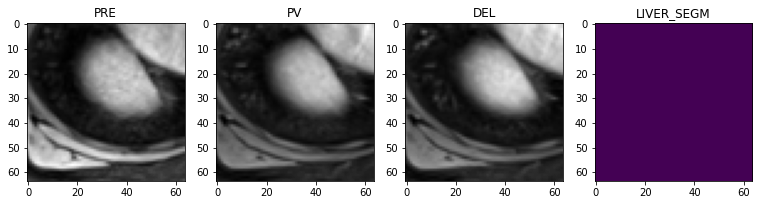

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.06787970662117004
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.05390229821205139
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.057606734335422516


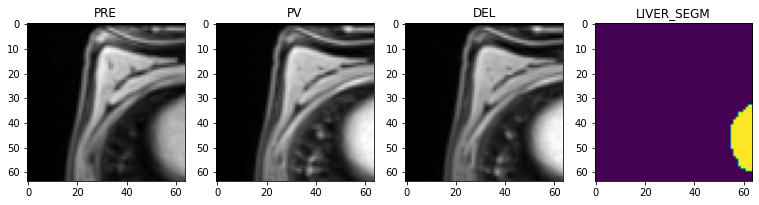

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.9032987952232361
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.2419061660766602
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.1338282823562622


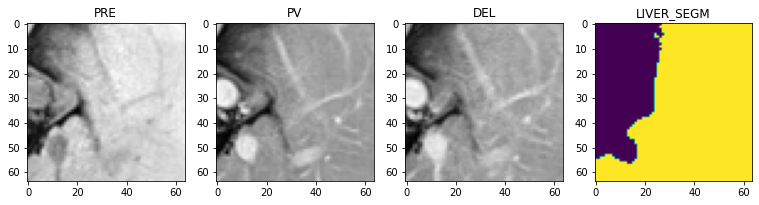

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.3862399160861969
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5594015717506409
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.491960734128952


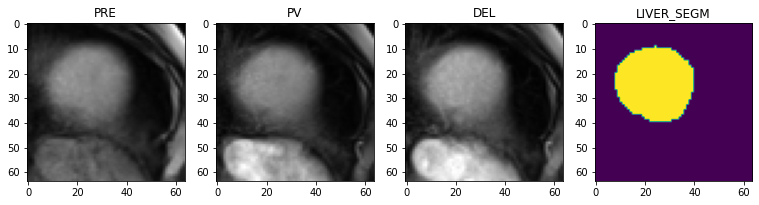

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6211618185043335
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.9412379264831543
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.8725442886352539


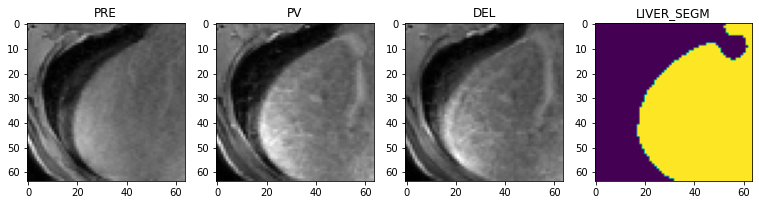

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.24267442524433136
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.2127547562122345
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.20667995512485504


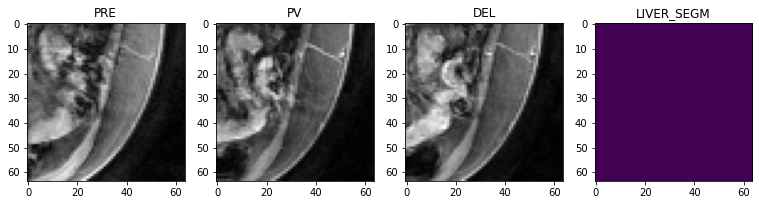

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.050246283411979675
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.10300491005182266
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.04865400493144989


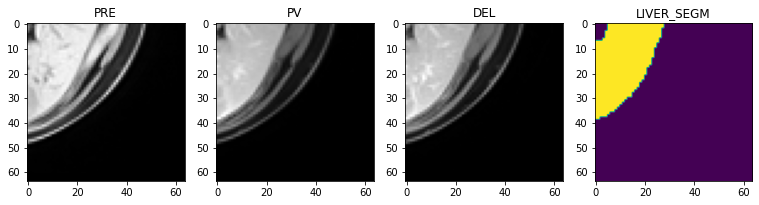

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7911372780799866
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.1019750833511353
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.9645370244979858


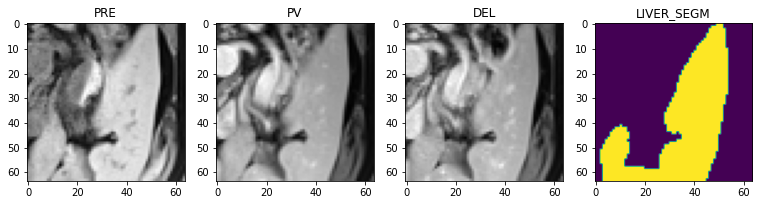

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.08999752253293991
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.12562201917171478
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.11783425509929657


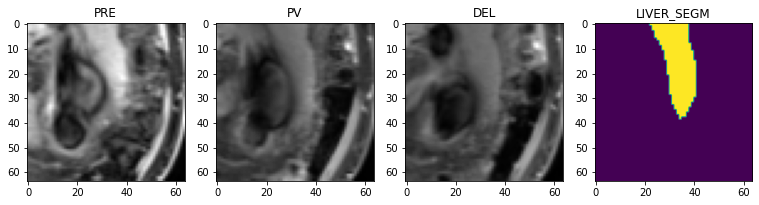

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7294204831123352
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.87534099817276
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.7627931833267212


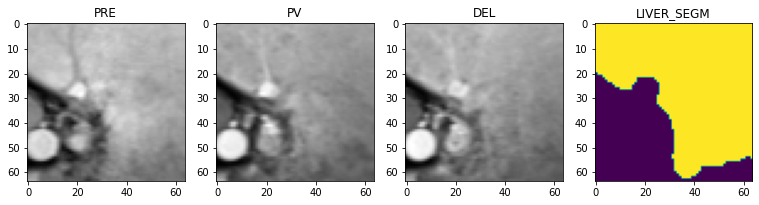

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['PRE'].shape[0]

for i in range(num_display):
    PRE, PV, DEL , liver_label = (check_data['PRE'][i][0],check_data['PV'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])


    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))



    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 4, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 4, 2)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 4 ,4)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=3, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        pre_images =  batch["PRE"]
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]
        
        images = torch.cat((pre_images, pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,3,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pre_images =  batch["PRE"]
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]

        
        images = torch.cat((pre_images, pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,3,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       9,618
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,189,649
Trainable params: 1,189,649
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 1.57
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-PV-DEL-Net/'


In [17]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [18]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0880-val_loss=0.07.ckpt')

In [19]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [20]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        if keep:
            dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
        else:
                
            # Calculate Dice on the raw output
            dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            
            
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            pv_images =  test_data["PV"].to(device)
            del_images =  test_data["DEL"].to(device)

            x = torch.cat((pre_images, pv_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                pv_img = pv_images.detach().cpu()
                del_img = del_images.detach().cpu()



                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 5, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 2)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 3)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 4)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 5, 5)
                plt.title('PRED')
                plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PRE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PRE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PRE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PRE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [21]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL'

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.9719403982162476
1.0443556000105805
inf
0.9719403982162476
1.0443556000105805
inf
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


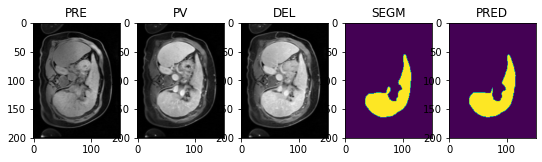

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100998852_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 47 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarnin

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 47 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the g

0.9779521226882935
5.505077318098292
inf
0.9792606830596924
1.3574409911838252
0.30308986526415294
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


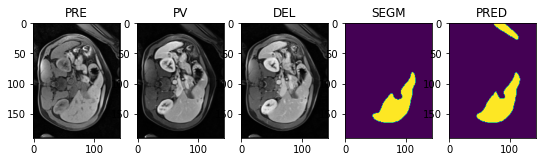

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12370686_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.945415735244751
10.380693221921392
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9660177230834961
1.10424713575181
inf
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


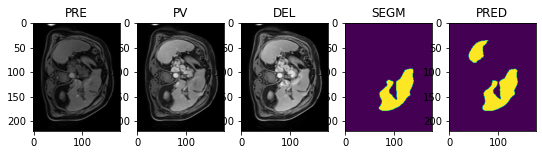

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104184251_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 220 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

0.9668727517127991
7.911231683240145
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 220 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 220 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


0.9694464206695557
1.378409654565081
inf
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


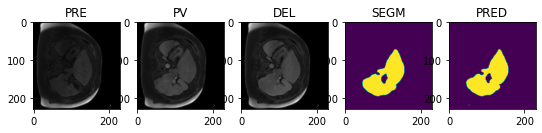

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100353838_T1_PRE_REG_segm.nii.gz
0.9275039434432983
7.844291884898986
inf
0.9292564392089844
2.268324336478214
inf
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


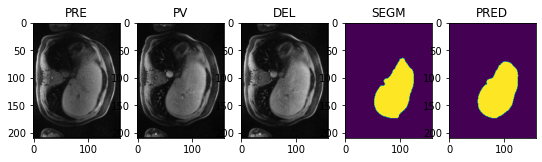

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11655071_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 160 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWar

0.950935423374176
2.9183900141027426
inf
0.954240083694458
1.2716012733964879
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


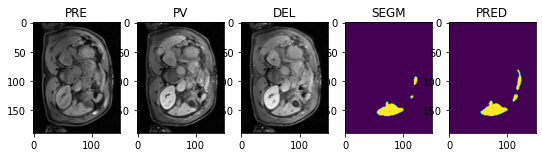

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105258820_T1_PRE_REG_segm.nii.gz
0.9507721066474915
12.308229002092737
inf
0.9635124206542969
1.5926767981152834
inf
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


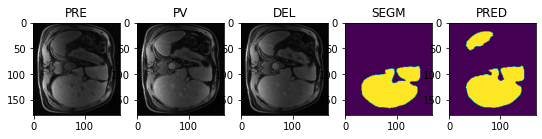

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/10782833_T1_PRE_REG_segm.nii.gz
0.9816416501998901
3.0580703721183156
inf
0.9822746515274048
1.160451324499268
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


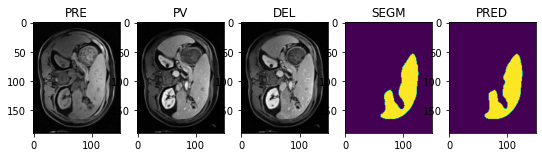

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105047582_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 159 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.9500415921211243
3.3466163382435
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 159 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: th

0.9559885263442993
1.6560495973602471
inf
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


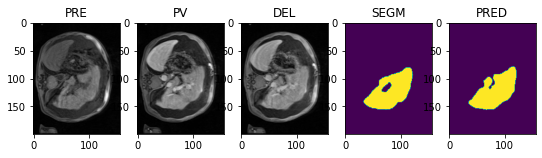

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100559269_T1_PRE_REG_segm.nii.gz
0.8784169554710388
13.417689603999811
inf
0.8784169554710388
13.417689603999811
inf
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


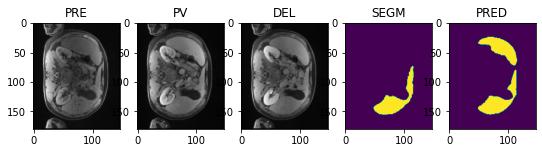

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11157922_T1_PRE_REG_segm.nii.gz
0.9655399918556213
4.461370770816844
inf
0.9659067988395691
3.2810581986314142
0.5885190097965195
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


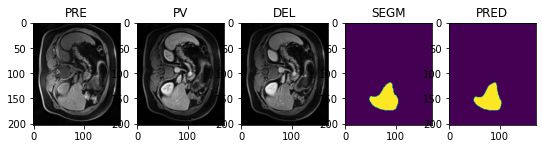

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103977998_T1_PRE_REG_segm.nii.gz
0.9702694416046143
1.6731055529889591
inf
0.9702701568603516
1.6731055529889591
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


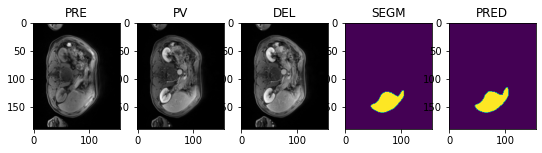

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106605970_T1_PRE_REG_segm.nii.gz
0.9417953491210938
9.916707549403636
inf
0.9490082263946533
4.633541720257907
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


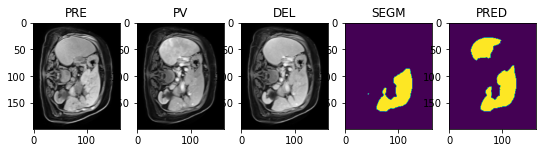

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101166449_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9389611482620239
44.01772721451337
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9590147733688354
2.5533329403786054
inf
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


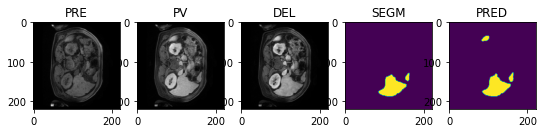

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101693803_T1_PRE_REG_segm.nii.gz
0.9743998050689697
1.1316169275542893
0.28422518756299187
0.9744133353233337
1.1316169275542893
0.27558800146682855
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


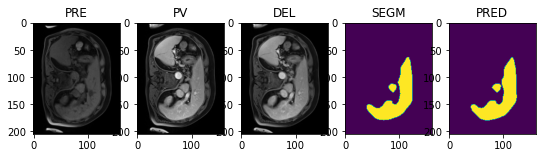

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100488381_T1_PRE_REG_segm.nii.gz
0.9551841616630554
7.325874935133923
inf
0.9565963745117188
2.6920579708482086
inf
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


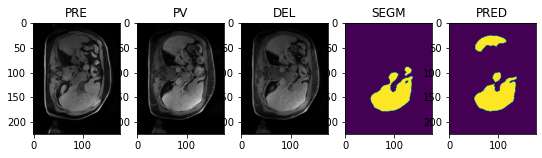

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101446184_T1_PRE_REG_segm.nii.gz
0.9473006725311279
1.4434122243626426
inf
0.9473072290420532
1.4434122243626426
inf
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


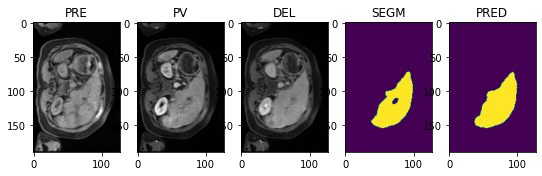

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12132879_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 86 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 86 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWa

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 86 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 86 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: t

0.966713547706604
1.071682290529921
inf
0.9667140245437622
1.071682290529921
inf
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


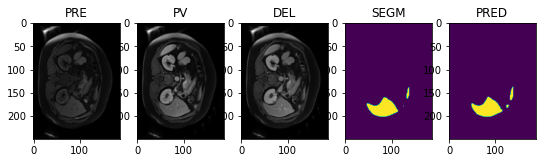

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100207522_T1_PRE_REG_segm.nii.gz
0.9509617686271667
11.11240700281978
inf
0.9744167327880859
1.4625502907684684
inf
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


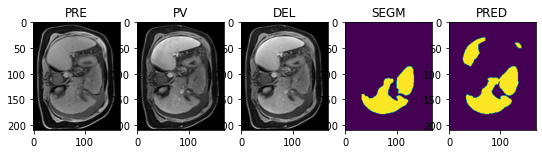

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104350920_T1_PRE_REG_segm.nii.gz
0.9693806171417236
3.833737859038378
inf
0.9701292514801025
1.5194884694482385
0.36735435807114175
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


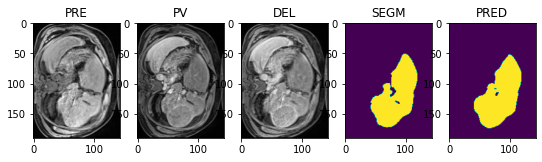

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103442524_T1_PRE_REG_segm.nii.gz
0.9769824743270874
2.380917660551386
inf
0.9773339629173279
1.437137756245167
inf
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


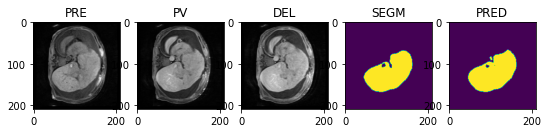

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100354995_T1_PRE_REG_segm.nii.gz
0.9725878238677979
4.6768106880100175
inf
0.9738154411315918
1.3030669694170527
0.3247645679806144
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


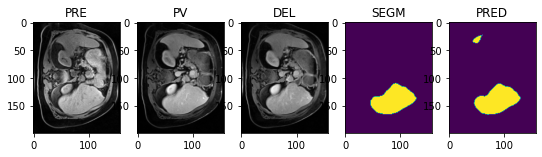

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12169194_T1_PRE_REG_segm.nii.gz
0.9400956034660339
4.760275045950509
inf
0.9428836107254028
1.6021171512136672
inf
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


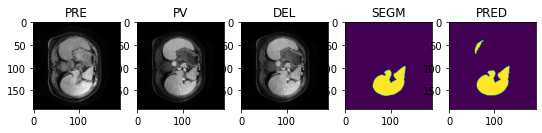

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/9464709_T1_PRE_REG_segm.nii.gz
0.965766191482544
9.841104446117598
inf
0.9755710363388062
0.9182468334846294
inf
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


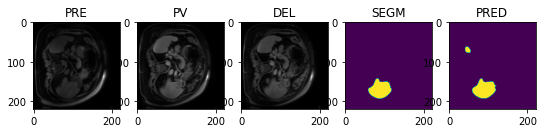

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E102885531_T1_PRE_REG_segm.nii.gz
0.9724434614181519
1.8120765500089917
0.4469558929983344
0.9724434614181519
1.8120765500089917
0.4469558929983344
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


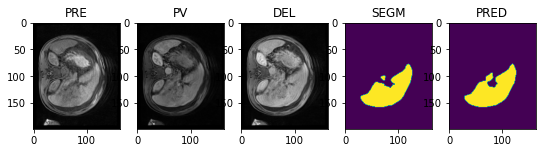

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106731917_T1_PRE_REG_segm.nii.gz
0.9753336906433105
5.707295096433338
inf
0.9758377075195312
2.124795096433339
inf
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


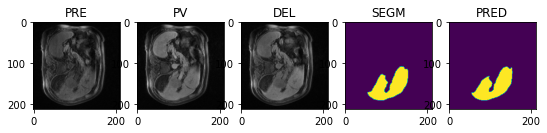

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105877173_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.967158317565918
1.322152281725923
inf
0.967158317565918
1.322152281725923
inf
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


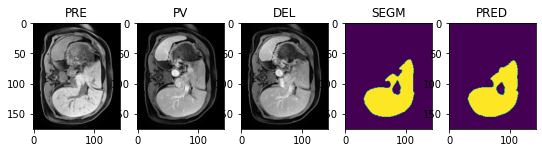

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106096969_T1_PRE_REG_segm.nii.gz
0.9659684300422668
4.256892181604736
inf
0.9692578315734863
1.2282357830906743
inf
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


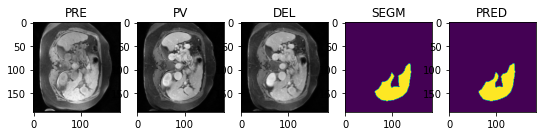

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11571840_T1_PRE_REG_segm.nii.gz
0.9728729128837585
1.483563431066182
inf
0.9728732109069824
1.483563431066182
inf
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


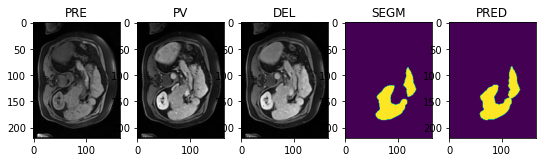

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101753253_T1_PRE_REG_segm.nii.gz
0.9773723483085632
1.0176142023148533
inf
0.9773723483085632
1.0176142023148533
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


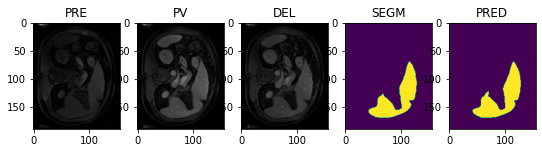

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103922902_T1_PRE_REG_segm.nii.gz
0.9407586455345154
18.69210851617119
inf
0.9740903973579407
1.999783731995492
0.42464643605834557
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


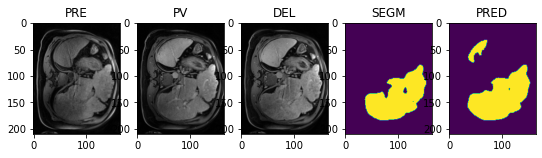

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101453378_T1_PRE_REG_segm.nii.gz
0.9462096095085144
19.954189168726263
inf
0.9560657739639282
2.7941778235895836
inf
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


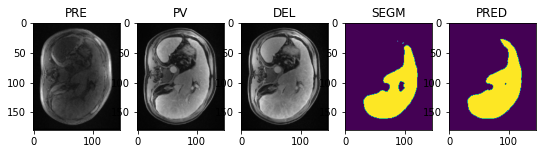

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11397044_T1_PRE_REG_segm.nii.gz
0.9617520570755005
1.4192167694336861
inf
0.9617564678192139
1.4192167694336861
inf
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


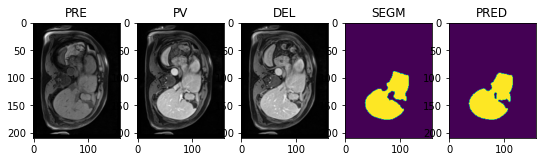

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12922235_T1_PRE_REG_segm.nii.gz
0.9603742361068726
9.505336891020903
inf
0.9769623279571533
1.481549592985936
0.3582908384774793
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


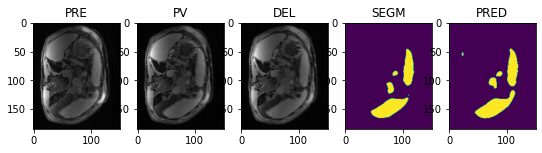

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/10939089_T1_PRE_REG_segm.nii.gz
0.976154088973999
2.778635883819162
inf
0.9776608943939209
1.079036274891425
0.23832314935111187
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


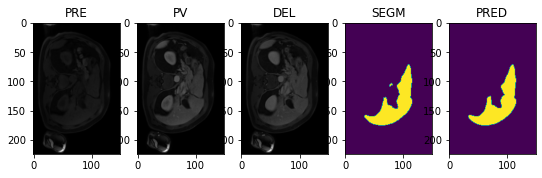

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12957044_T1_PRE_REG_segm.nii.gz
0.9731332063674927
3.1797842616773186
inf
0.9745832681655884
1.4752939106285907
0.3953224011427686
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


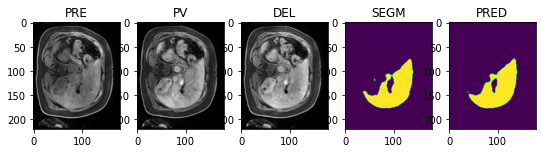

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107891018_T1_PRE_REG_segm.nii.gz
0.9777388572692871
1.4316287940270662
inf
0.9778239130973816
1.1326287940270663
inf
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


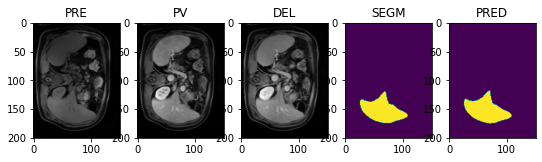

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104332583_T1_PRE_REG_segm.nii.gz
0.9770761728286743
0.9015662476087669
0.24985407429175155
0.9770761728286743
0.9015662476087669
0.24985407429175155
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


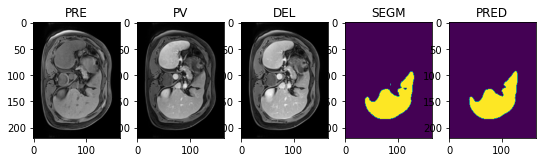

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101547088_T1_PRE_REG_segm.nii.gz
0.9619646072387695
10.35165008402937
inf
0.9634125828742981
1.2668890740141847
inf
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


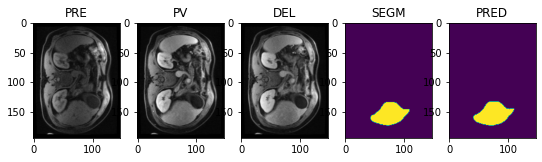

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11524268_T1_PRE_REG_segm.nii.gz
0.9778211116790771
1.0496444650154328
inf
0.9778211116790771
1.0496444650154328
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


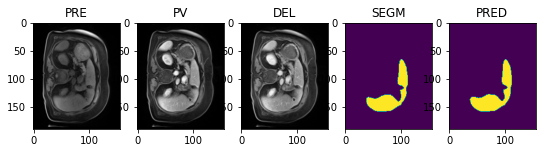

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106458466_T1_PRE_REG_segm.nii.gz
0.9563007354736328
1.9600169969577044
inf
0.9563007354736328
1.9600169969577044
inf
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


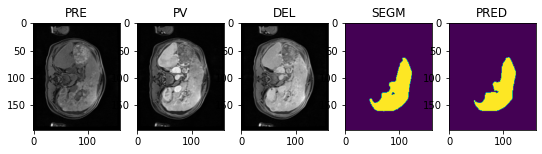

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107235152_T1_PRE_REG_segm.nii.gz
0.9680822491645813
1.7802820182897845
0.440776859435022
0.9680822491645813
1.7802820182897845
0.440776859435022
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


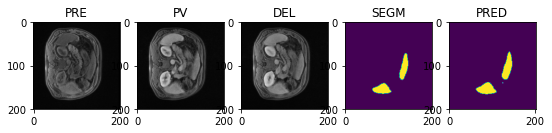

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105198762_T1_PRE_REG_segm.nii.gz
0.9620153903961182
2.7536081953130114
inf
0.9620153903961182
2.7536081953130114
inf
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


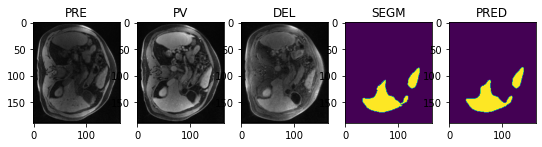

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11148247_T1_PRE_REG_segm.nii.gz
0.9751505255699158
1.4228856157446024
0.32947051096383284
0.9751505255699158
1.4228856157446024
0.32947051096383284
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


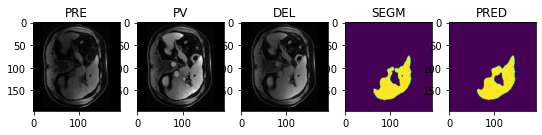

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106751045_T1_PRE_REG_segm.nii.gz
0.9604759812355042
2.0931305662711375
inf
0.9604955911636353
2.0931305662711375
inf
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


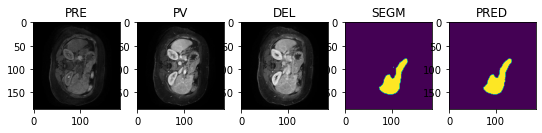

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/9648994_T1_PRE_REG_segm.nii.gz
0.9682859778404236
4.645356976603271
inf
0.9698268175125122
1.505013061259357
0.36322999318080385
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


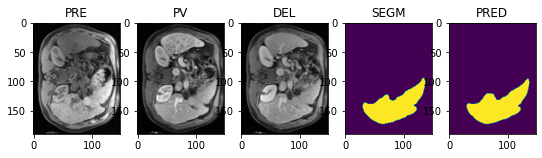

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E102928841_T1_PRE_REG_segm.nii.gz
0.968654453754425
1.8398574161358807
inf
0.9693484902381897
1.1227324161358816
inf
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


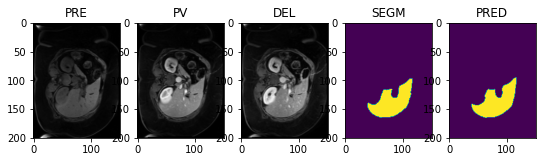

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105426183_T1_PRE_REG_segm.nii.gz
0.9757278561592102
2.930828205792094
inf
0.9762788414955139
1.1842954544118987
0.3180166511031117
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


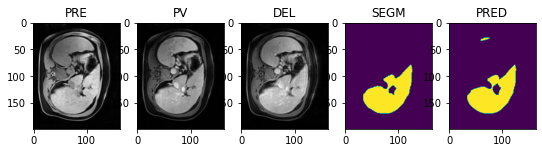

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100142484_T1_PRE_REG_segm.nii.gz
0.9766103625297546
1.5441108542482054
inf
0.9766185283660889
1.5441108542482054
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


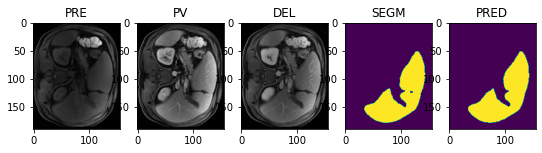

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105829099_T1_PRE_REG_segm.nii.gz
0.940514326095581
8.215832477480202
inf
0.946542501449585
2.8266860971489876
inf
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


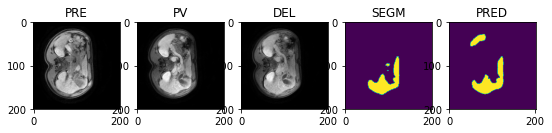

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/9586289_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 143 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9328655004501343
2.3676835712298656
inf
0.9328655004501343
2.3676835712298656
inf
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


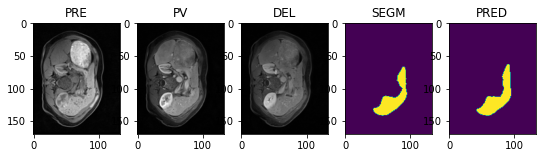

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107156072_T1_PRE_REG_segm.nii.gz
0.9708641171455383
1.0550324951001941
inf
0.970953106880188
1.0550324951001941
inf
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


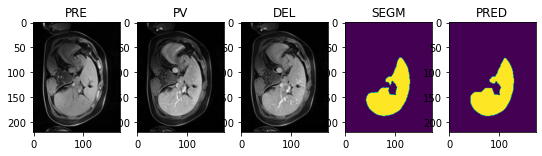

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104998309_T1_PRE_REG_segm.nii.gz
0.9595266580581665
2.872535759022436
inf
0.959625244140625
1.4502995781179138
inf
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


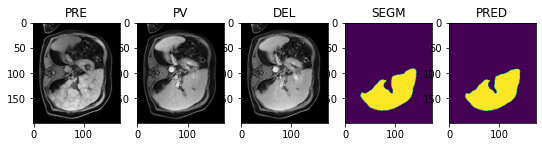

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105615985_T1_PRE_REG_segm.nii.gz
0.9674042463302612
1.3242438440835043
inf
0.9674042463302612
1.3242438440835043
inf
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


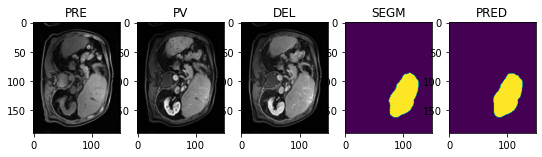

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12916368_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9678102731704712
3.0262327621013947
inf
0.9682517647743225
1.608137524006157
inf
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


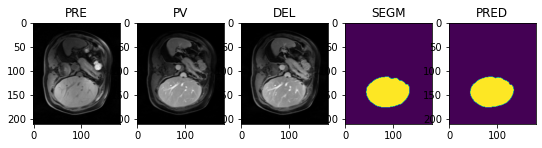

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103814356_T1_PRE_REG_segm.nii.gz
0.959288477897644
7.348958219095733
inf
0.9596561789512634
4.245223568645406
inf
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


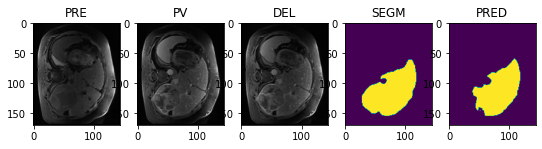

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11022925_T1_PRE_REG_segm.nii.gz
0.9520401954650879
38.278911871248845
inf
0.9657412767410278
1.2885386171377742
inf
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


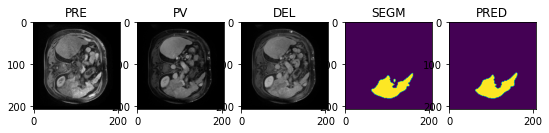

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106533478_T1_PRE_REG_segm.nii.gz
0.9707766771316528
1.6394188917262444
inf
0.9707767963409424
1.6394188917262444
inf
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


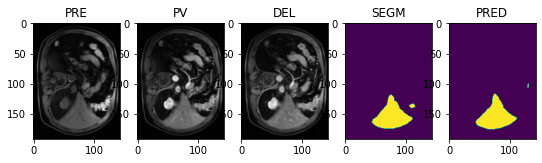

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106851724_T1_PRE_REG_segm.nii.gz
0.9514135122299194
2.2409472417560727
inf
0.9514173269271851
2.2409472417560727
inf
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


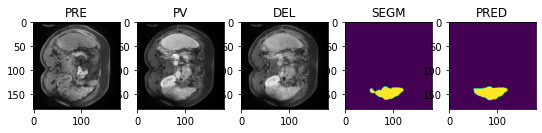

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103511968_T1_PRE_REG_segm.nii.gz
0.9712391495704651
4.576112608512117
1.4067876328068118
0.9759637117385864
1.2596545369616639
0.32026494776091824
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


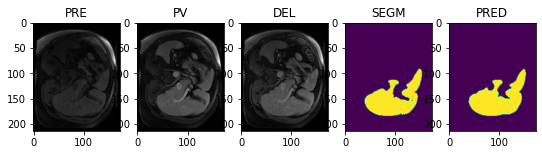

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107553107_T1_PRE_REG_segm.nii.gz
0.9534264802932739
32.37740833939251
inf
0.966742753982544
1.2984640756707853
0.3122266510340164
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


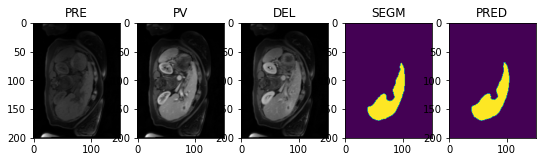

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100588448_T1_PRE_REG_segm.nii.gz
0.956390380859375
7.9825935521628395
inf
0.9572190046310425
2.0725576907732495
inf
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


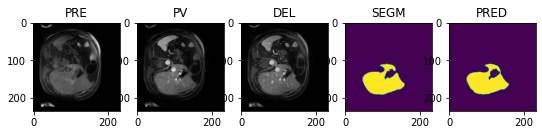

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104134228_T1_PRE_REG_segm.nii.gz
0.9538981914520264
42.546074169779196
inf
0.9690543413162231
1.148405758263982
0.29416833315562485
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


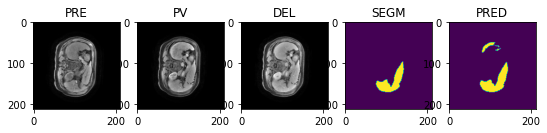

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101686218_T1_PRE_REG_segm.nii.gz
0.9588394165039062
2.0184176092921007
inf
0.9588394165039062
2.0184176092921007
inf
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


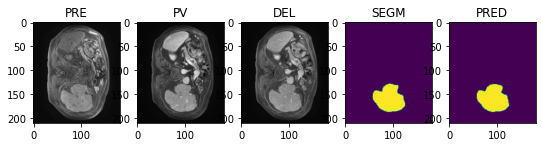

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E100967188_T1_PRE_REG_segm.nii.gz
0.9689610004425049
3.920880357668727
inf
0.9692268371582031
1.485389286240156
inf
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


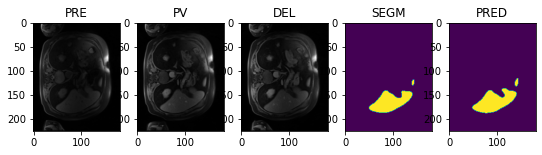

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107476766_T1_PRE_REG_segm.nii.gz
0.9398509860038757
24.18649839716208
inf
0.9549200534820557
1.1913926829147719
inf
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


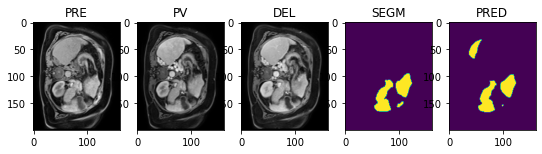

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104250009_T1_PRE_REG_segm.nii.gz
0.9794948101043701
2.195273419447778
inf
0.9798678159713745
1.2124844747241608
0.2645674688970823
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


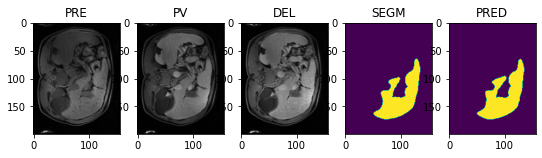

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105152299_T1_PRE_REG_segm.nii.gz
0.9552169442176819
3.773211531862963
inf
0.9558777213096619
1.2783162439048483
inf
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


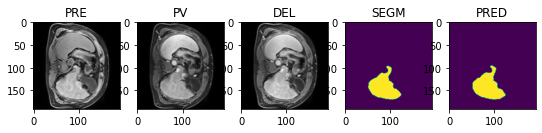

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/11308203_T1_PRE_REG_segm.nii.gz
0.980178952217102
1.2323515907574656
inf
0.980178952217102
1.2323515907574656
inf
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


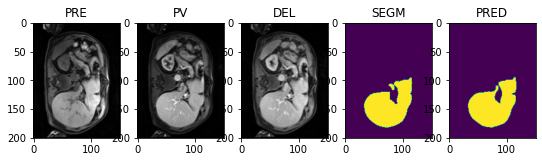

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107046127_T1_PRE_REG_segm.nii.gz
0.9524120092391968
1.8868607879779793
inf
0.9524120092391968
1.8868607879779793
inf
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


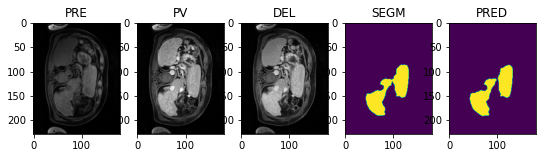

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/13106408_T1_PRE_REG_segm.nii.gz
0.9785356521606445
3.0160995518124265
inf
0.9795125722885132
0.9973682054420553
0.23722531301660746
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


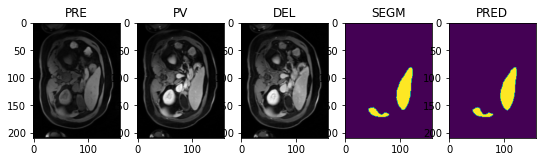

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E102486953_T1_PRE_REG_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWar

0.9382179379463196
15.644411710923205
inf
0.9598040580749512
1.5428894062560903
inf
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


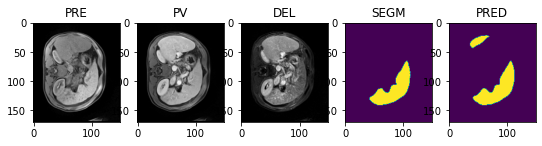

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101055640_T1_PRE_REG_segm.nii.gz
0.9724443554878235
5.460593719428515
inf
0.9737313985824585
4.740796297324873
inf
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


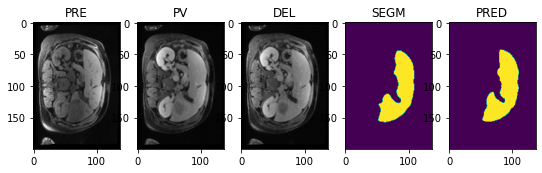

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/10807315_T1_PRE_REG_segm.nii.gz
0.9185267686843872
13.700195957215339
inf
0.9828157424926758
1.2104924499615255
0.24420257476252094
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


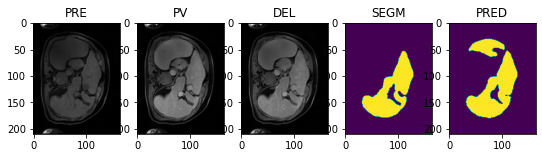

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/13170972_T1_PRE_REG_segm.nii.gz
0.923454999923706
15.143397201584257
inf
0.9242351651191711
10.309648207668953
inf
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


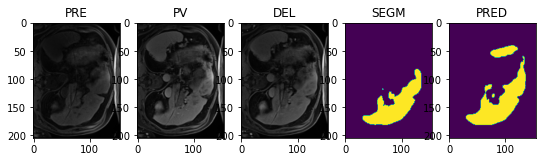

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104594843_T1_PRE_REG_segm.nii.gz
0.97211754322052
1.3876824638685266
inf
0.97211754322052
1.3876824638685266
inf
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


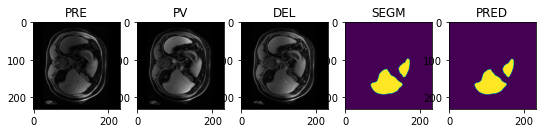

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104034609_T1_PRE_REG_segm.nii.gz
0.97395920753479
7.523378423170597
inf
0.9794732928276062
1.0081987905792698
0.2567262495446951
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


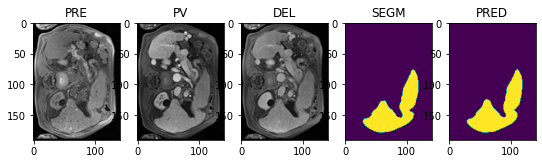

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107774979_T1_PRE_REG_segm.nii.gz
0.969326913356781
1.306753747326812
inf
0.969326913356781
1.306753747326812
inf
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


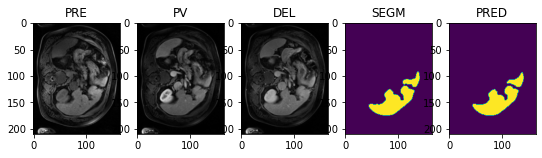

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104900599_T1_PRE_REG_segm.nii.gz
0.9762297868728638
1.501074709491348
inf
0.97623211145401
1.501074709491348
inf
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


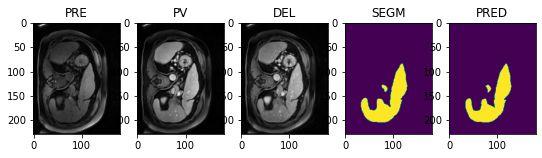

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E104657225_T1_PRE_REG_segm.nii.gz
0.9602221250534058
2.7391297623749638
inf
0.9603711366653442
1.929772220475523
inf
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


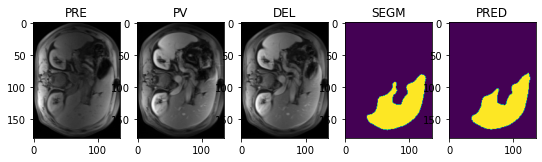

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105599954_T1_PRE_REG_segm.nii.gz
0.9588572978973389
4.121796587235401
inf
0.9594957828521729
2.2792510116473266
inf
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


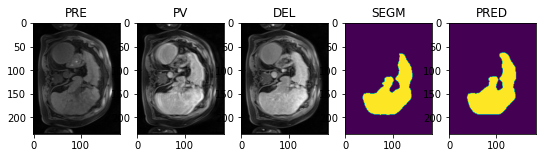

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103570649_T1_PRE_REG_segm.nii.gz
0.9726403951644897
1.330834871039403
inf
0.9726403951644897
1.330834871039403
inf
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


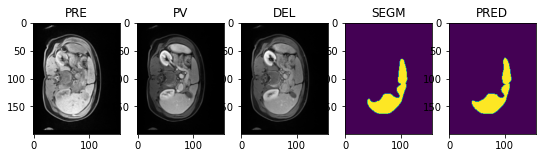

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E105504009_T1_PRE_REG_segm.nii.gz
0.9771056771278381
1.281704865797107
0.3406708114660284
0.9771056771278381
1.281704865797107
0.3406708114660284
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


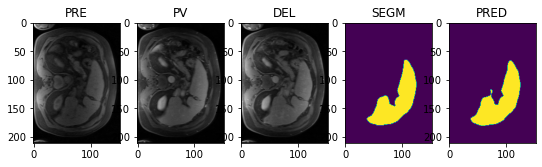

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E103831361_T1_PRE_REG_segm.nii.gz
0.9672518372535706
12.19325263088145
inf
0.973625123500824
1.7378783514551674
inf
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


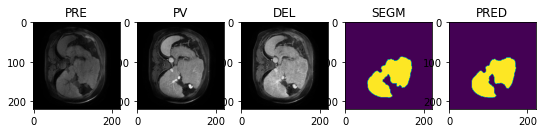

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/10843891_T1_PRE_REG_segm.nii.gz
0.961106538772583
3.048570672999703
inf
0.9617165327072144
1.7351846177889705
inf
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


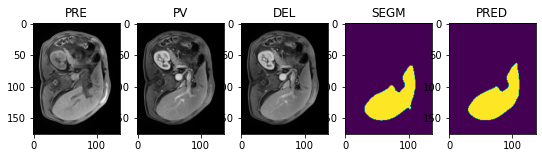

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E101762106_T1_PRE_REG_segm.nii.gz
0.9634368419647217
5.9340656644973695
inf
0.96632981300354
1.3560233364550431
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


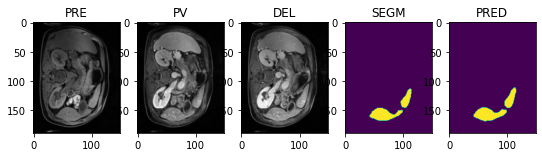

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/12543786_T1_PRE_REG_segm.nii.gz
0.9604007005691528
1.6240060376668373
inf
0.9604012370109558
1.6240060376668373
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


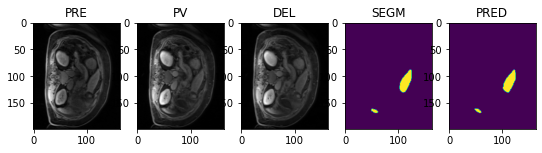

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E107077373_T1_PRE_REG_segm.nii.gz
0.9713882207870483
1.172068382585922
inf
0.971407949924469
1.1629359624945979
inf
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


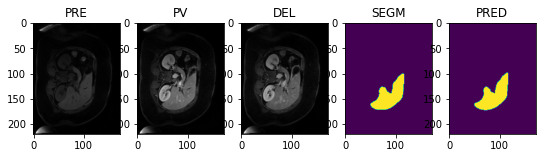

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-PV-DEL/E106501028_T1_PRE_REG_segm.nii.gz
[0.9719403982162476, 0.9779521226882935, 0.945415735244751, 0.9668727517127991, 0.9275039434432983, 0.950935423374176, 0.9507721066474915, 0.9816416501998901, 0.9500415921211243, 0.8784169554710388, 0.9655399918556213, 0.9702694416046143, 0.9417953491210938, 0.9389611482620239, 0.9743998050689697, 0.9551841616630554, 0.9473006725311279, 0.966713547706604, 0.9509617686271667, 0.9693806171417236, 0.9769824743270874, 0.9725878238677979, 0.9400956034660339, 0.965766191482544, 0.9724434614181519, 0.9753336906433105, 0.967158317565918, 0.9659684300422668, 0.9728729128837585, 0.9773723483085632, 0.9407586455345154, 0.9462096095085144, 0.9617520570755005, 0.9603742361068726, 0.976154088973999, 0.9731332063674927, 0.9777388572692871, 0.9770761728286743, 0.9619646072387695, 0.9778211116790771, 0.9563007354736328, 0.9680822491645813, 0.9620153903961182, 0.9751505255

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.971940   0.971940   1.044356   1.044356       0.008973   
1  0.977952   0.979261   5.505077   1.357441       0.004479   
2  0.945416   0.966018  10.380693   1.104247       0.005356   
3  0.966873   0.969446   7.911232   1.378410       0.013060   
4  0.927504   0.929256   7.844292   2.268324       0.007221   

                                AUTOMATED-LIVER-SEGM      EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-PV-DEL  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-PV-DEL  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-PV-DEL  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-PV-DEL  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-PV-DEL

In [60]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '3mpMRI-PRE-PV-DEL'
df_test_results.head()

In [61]:
df_test_results.describe()

DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  88.000000  88.000000  88.000000  88.000000      88.000000
mean    0.961256   0.965386   6.527379   1.892056       0.005222
std     0.016548   0.014819   8.671278   1.709194       0.001968
min     0.878417   0.878417   0.901566   0.901566       0.003536
25%     0.953173   0.959648   1.604032   1.231323       0.004152
50%     0.966341   0.969242   3.037402   1.456425       0.004478
75%     0.972601   0.974725   7.861027   1.897589       0.005293
max     0.981642   0.982816  44.017727  13.417690       0.013060

In [62]:
df_test_results.to_csv('../Results/Results-3mpMRI-Net_PRE-PV-DEL.csv')